<a href="https://colab.research.google.com/github/Bharat0207/TwitterTweetAnalyzer/blob/main/Viraltweetpredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from imblearn.over_sampling import SMOTE
import sklearn as sk
from google.colab import files

# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

uploaded = files.upload()

filename = list(uploaded.keys())[0]

df = pd.read_csv(filename)

df.head(5)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving tweets_cleaned_no_outliers.csv to tweets_cleaned_no_outliers.csv


,Tweet_ID,Username,Text_cleaned,Retweets,Likes,month,date,time,Followers,Hashtags_cleaned,hashtags1,hashtags2,hashtags3,tokens,Category,Compound_Score,Sentiment,Month,DayOfWeek
0,1,julie81,party least receive say or single. prevent pre...,2,25,Jan,2023-01-30,11:00:51,60,"party, least, receive",party,least,receive,"['party', 'receive', 'single', 'prevent', 'pre...",finance,0.8885,Positive,January,Monday
1,2,richardhester,hotel still congress may member staff. media d...,35,29,Jan,2023-01-02,22:45:58,84,"hotel, still, congress",hotel,still,congress,"['hotel', 'congress', 'member', 'staff', 'medi...",politics,0.2960,Positive,January,Monday
2,3,williamsjoseph,nice be her debate industry that year. film wh...,51,25,Jan,2023-01-18,11:25:19,89,"nice, debate, industry",nice,debate,industry,"['nice', 'debate', 'industry', 'year', 'film',...",cinema,0.8481,Positive,January,Wednesday
3,4,danielsmary,laugh explain situation career occur serious. ...,37,18,Apr,2023-04-10,22:06:29,76,"laugh, explain, situation",laugh,explain,situation,"['laugh', 'explain', 'situation', 'career', 'o...",technology,0.6249,Positive,April,Monday
4,5,carlwarren,involve sense former often approach government...,27,80,Jan,2023-01-24,07:12:21,115,"involve, sense, former",involve,sense,former,"['involve', 'sense', 'approach', 'government',...",technology,0.6705,Positive,January,Tuesday


In [ ]:
print ("pandas " ,pd.__version__)
print ("pandas " ,np.__version__)
print("sklearn", sk.__version__)

pandas  2.2.2
pandas  2.0.2
sklearn 1.6.1


In [ ]:
df['viral'] = df['Retweets'].apply(lambda x: 1 if x >= 50 else 0)

In [ ]:
category_encoded = pd.get_dummies(df['Category'], prefix='cat')
day_dummies = pd.get_dummies(df['DayOfWeek'], prefix='day')
hour_dummies = pd.get_dummies(df['Month'], prefix='month')
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

# Extract hour, minute, second
df['hour'] = df['time'].apply(lambda t: t.hour)
df['minute'] = df['time'].apply(lambda t: t.minute)
df['second'] = df['time'].apply(lambda t: t.second)
time_features = df[['hour', 'minute', 'second']].to_numpy()

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df['Text_cleaned']).toarray()

# Add numeric metadata (followers, time, etc.)
metadata_features = df[['Followers','Likes']]  # Add relevant columns
X_meta = metadata_features.fillna(0).values


# Combine all features
X = np.hstack((X_text, X_meta, category_encoded,day_dummies,hour_dummies,time_features,))
y = df['viral']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


clf = RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1016
           1       0.88      0.88      0.88       967

    accuracy                           0.88      1983
   macro avg       0.88      0.88      0.88      1983
weighted avg       0.88      0.88      0.88      1983



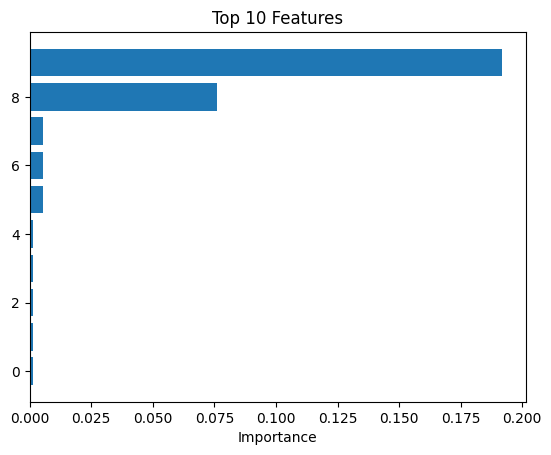

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices])
plt.xlabel("Importance")
plt.title("Top 10 Features")
plt.show()

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)

for metric in scoring:
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

accuracy: 0.8976
precision: 0.8999
recall: 0.8969
f1: 0.8983


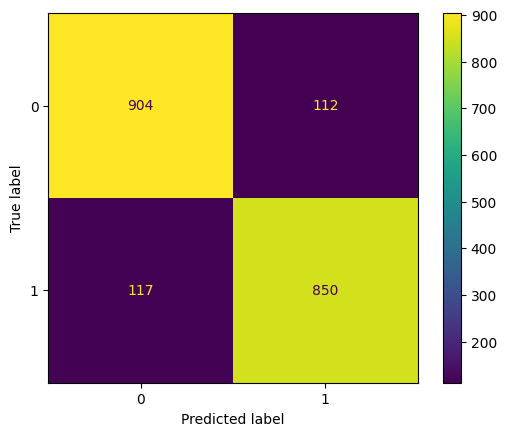

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8845184064548663


In [ ]:
print(df['viral'].value_counts())

viral
1    4997
0    4915
Name: count, dtype: int64


In [ ]:
import pickle
with open ('viral.pkl','wb') as file:
    pickle.dump (clf, file)

In [ ]:
import pickle
with open ('vector.pkl','wb') as file:
    pickle.dump (vectorizer, file)

In [ ]:
import pickle
with open ('category.pkl','wb') as file:
    pickle.dump (category_encoded, file)
with open ('days.pkl','wb') as file:
    pickle.dump (day_dummies, file)
with open ('month.pkl','wb') as file:
    pickle.dump (hour_dummies, file)
with open ('time.pkl','wb') as file:
    pickle.dump (time_features, file)